# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

When calculating the value of a vehicle, several factors typically have a significant impact. The importance of these factors can vary depending on the market and the type of vehicle, but generally, the following are considered key determinants:

Make and Model: Certain brands and models are more sought after due to their reputation for quality, reliability, performance, or luxury. High-demand models tend to retain value better.

Year and Age: The age of the vehicle, often indicated by the model year, is a crucial factor. Newer vehicles usually have more advanced technology, better fuel efficiency, and lower accumulated wear and tear.

Mileage/Odometer Reading: Higher mileage typically leads to lower value due to the wear and tear associated with extensive use.

Condition: This includes both mechanical and aesthetic aspects. Vehicles in better condition, with no need for significant repairs or bodywork, are valued higher.

Accident History: A history of accidents can significantly reduce a vehicle's value, especially if the accidents were severe.

Vehicle History: This includes not just accident history but also ownership history (single owner vs. multiple owners), maintenance records, and whether it was used for personal or commercial purposes.

Features and Options: Certain features like advanced safety systems, infotainment, luxury interiors, or high-performance components can add to a vehicle's value.

Market Trends and Demand: The local demand for certain types of vehicles (e.g., SUVs, electric cars) can influence their value. Also, broader market trends, such as fuel prices, can impact the value of certain types of vehicles (like gas-guzzlers vs. fuel-efficient models).

Economic Factors: General economic conditions, including interest rates and consumer confidence, can affect vehicle values. In a strong economy, people might be willing to pay more for vehicles.

Fuel Efficiency: Especially in times of high fuel prices, more fuel-efficient vehicles tend to retain their value better.

Location: Vehicle values can vary by region due to differences in demand and usage. For example, four-wheel drives might be more valued in rural or mountainous areas.

Color: While it might seem minor, the color of a vehicle can affect its resale value. Common and popular colors like white, black, and silver often have better resale values.





### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Given the columns in vechiles.csv dataset and the factors that typically impact vehicle value, the most important columns to consider for the analysis would likely be:

1) Year (year): The model year of the car is a strong indicator of its age and can significantly influence its value.

2) Manufacturer (manufacturer): The brand of the car often affects its value, as some brands are perceived as more reliable or desirable.

3) Model (model): Different models have varying levels of demand and reputation, which can impact their resale value.

4) Odometer (odometer): The mileage on the car is a key indicator of wear and tear. Generally, lower mileage cars are valued higher.

5) Condition (condition): The overall state of the car, including both mechanical and aesthetic condition, is crucial for determining its value.

6) Transmission (transmission): The type of transmission (automatic, manual) can affect a car's desirability and thus its value.

7) Fuel Type (fuel): Fuel efficiency and type (gas, diesel, electric, hybrid) can influence a car's value, especially in certain markets or during times of fluctuating fuel prices.

8) Drive Type (drive): Whether the car is front-wheel drive, rear-wheel drive, or all-wheel drive can impact its value, particularly in regions with specific weather conditions.

9) Type (type): The body type of the vehicle (SUV, sedan, truck, etc.) can affect its value based on consumer preferences and trends.

10) Paint Color (paint_color): While not as significant as other factors, the color can play a role in the car's appeal and value.

11) Title Status (title_status): Cars with a clean title generally have higher values than those with salvage or rebuilt titles.



### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [2321]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy import stats
import copy
import sys
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

In [2322]:
label_encoder = LabelEncoder()

In [2323]:
def load_data():
    df = pd.read_csv('data/vehicles.csv')
    #df.info()
    return df.copy()

In [2324]:
cars = load_data()

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [2325]:
def scope_data(df, manufacturer):
    newest_car_year = df['year'].max()
    cutoff_year = newest_car_year - 15
    df = df[df['year'] >= cutoff_year]
    df = df[df['manufacturer'] == manufacturer]
    df = df[['price', 'year', 'manufacturer', 'model', 'odometer', 'condition']]
    df = df.dropna(subset=['manufacturer'])
    df = df.dropna(subset=['model'])
    #df = df.dropna(subset=['odometer'])
    df['condition'] = df['condition'].fillna('Unknown')
    df['odometer'] = df['odometer'].fillna(df['odometer'].median())
    df['manufacturer_model'] = df['manufacturer'].astype(str) + " " + df['model'].astype(str)
    return df.copy()

In [2326]:
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

In [2327]:
def detect_outliers_by_model_and_year(df, column_to_check):
    outliers_dict = {}
    for model in df['manufacturer_model'].unique():
        model_data = df[df['manufacturer_model'] == model]
        for year in model_data['year'].unique():
            year_data = model_data[model_data['year'] == year]
            outliers = detect_outliers(year_data, column_to_check)

            # Storing outliers' information
            if not outliers.empty:
                outliers_dict[(model, year)] = outliers

    return outliers_dict

In [2328]:
def clean_outliers(df, outliers_dict):
    cleaned_cars = pd.DataFrame()

    for key, outliers in outliers_dict.items():
        manufacturer_model, year = key

        # Filter the subset for the current manufacturer_model and year
        subset_mask = (df['manufacturer_model'] == manufacturer_model) & (df['year'] == year)
        subset = df[subset_mask]

        # Keep rows that are not in outliers
        non_outliers = subset[~subset.index.isin(outliers.index)]
        
        # Append non-outliers to the cleaned DataFrame
        cleaned_cars = pd.concat([cleaned_cars, non_outliers])

    # Append all other data that wasn't processed (not in outliers_dict)
    for key in outliers_dict.keys():
        manufacturer_model, year = key
        df = df[~((df['manufacturer_model'] == manufacturer_model) & (df['year'] == year))]

    cleaned_cars = pd.concat([cleaned_cars, df])

    return cleaned_cars

In [2329]:
def encode_data(df):
    # Apply label encoding to each categorical column
    categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        
    return df.copy()

In [2330]:
cars = scope_data(cars, 'chevrolet')
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42686 entries, 28 to 426849
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               42686 non-null  int64  
 1   year                42686 non-null  float64
 2   manufacturer        42686 non-null  object 
 3   model               42686 non-null  object 
 4   odometer            42686 non-null  float64
 5   condition           42686 non-null  object 
 6   manufacturer_model  42686 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 2.6+ MB


In [2331]:
outliers_dict = detect_outliers_by_model_and_year(cars, 'price')
cars = clean_outliers(cars, outliers_dict)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39607 entries, 28 to 426847
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               39607 non-null  int64  
 1   year                39607 non-null  float64
 2   manufacturer        39607 non-null  object 
 3   model               39607 non-null  object 
 4   odometer            39607 non-null  float64
 5   condition           39607 non-null  object 
 6   manufacturer_model  39607 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 2.4+ MB


In [2332]:
unique_manufacturer_models = cars['manufacturer_model'].unique()
print(type(unique_manufacturer_models))
print(unique_manufacturer_models, len(unique_manufacturer_models))

<class 'numpy.ndarray'>
['chevrolet silverado 1500' 'chevrolet silverado 1500 crew'
 'chevrolet silverado 1500 double' ... 'chevrolet silverado 2500 duramax'
 'chevrolet cruze, 2lt' 'chevrolet 1500 z71'] 1718


In [2333]:
cars = encode_data(cars)
cars =  cars.drop(['manufacturer', 'model'], axis=1) 
cars

,price,year,odometer,condition,manufacturer_model
28,22590,2010.0,71229.0,3,916
1817,22590,2010.0,71229.0,3,916
3010,12882,2010.0,189509.0,1,916
3317,14700,2010.0,200392.0,0,916
10016,19999,2010.0,99219.0,1,916
...,...,...,...,...,...
426788,12995,2016.0,61127.0,4,492
426793,15999,2018.0,36465.0,1,528
426796,16990,2017.0,37448.0,3,1679
426801,14990,2017.0,58617.0,3,1673


price                 1.000000
year                  0.438075
condition             0.097661
manufacturer_model    0.002102
odometer             -0.159075
Name: price, dtype: float64


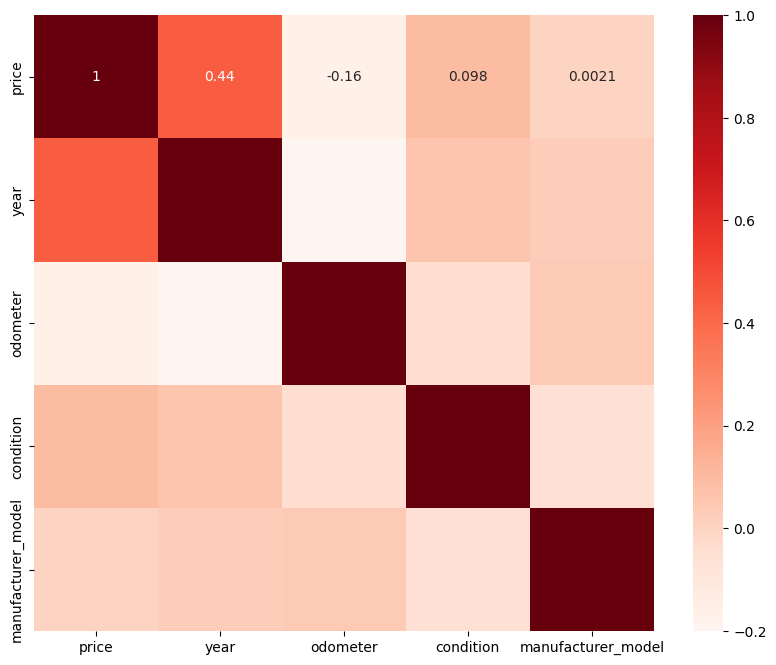

In [2334]:
# Correlation analysis all models
correlation_matrix = cars.corr()
# Get the correlation of all features with the target variable 'price'
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
# Print the correlation values
print(correlation_with_price)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.savefig('images/correclation_heatmap.png')
plt.show()

In [2335]:
def search_best_correlating_model(df):
    unique_models = df['manufacturer_model'].unique()
    model_with_most_strong_correlations = ''
    max_strong_correlations_with_price = ''
    max_strong_correlations = 0

    for carmodel in unique_models:
        # Filter the dataset for the specific model
        model_data = df[df['manufacturer_model'] == carmodel]
        model_data = model_data.drop(['manufacturer_model'], axis=1)
        
        # Ensure there's enough data for the specific model
        if model_data.shape[0] > 500:  # Choose a threshold value that makes sense for your dataset
            # Calculate the correlation matrix for the specific model
            correlation_matrix = model_data.corr()
            
            # Extract and sort the correlation with price
            correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
            
            # Count the number of features with strong correlation with price
            strong_correlations_count = sum(abs(correlation_with_price) > 0.3)

            # Update the model with the most strong correlations
            if strong_correlations_count > max_strong_correlations:
                max_strong_correlations = strong_correlations_count
                model_with_most_strong_correlations = carmodel
                max_strong_correlations_with_price = correlation_with_price

            # Display the results
            modelname = label_encoder.classes_[carmodel]
            #print(f"Correlation with price for {modelname}:")
            #print(correlation_with_price)
            #print("\n")
        
        return model_with_most_strong_correlations, max_strong_correlations_with_price, label_encoder.classes_[model_with_most_strong_correlations]
        


In [2336]:
best_correlating_model, best_correlations, carmodelname = search_best_correlating_model(cars)

# Get the actual model name using label_encoder
if best_correlating_model:
    modelname = label_encoder.classes_[best_correlating_model].title()
    #print(f"The model with the most features strongly correlated with price is '{modelname} encoded:{model_with_most_strong_correlations}' with {max_strong_correlations} strong correlations.")
    print(carmodelname, 'encoded value:', best_correlating_model)
    print(best_correlations)
else:
    print("No model found with a strong correlation with more than one feature.")
    


chevrolet silverado 1500 encoded value: 916
price        1.000000
year         0.584113
condition   -0.106940
odometer    -0.568025
Name: price, dtype: float64


In [2337]:
def get_carmodel_data(df, carmodel):
    carmodel_data = df[df['manufacturer_model'] == carmodel]
    carmodel_data = carmodel_data.drop(['manufacturer_model'], axis=1)
    return carmodel_data.copy()

In [2338]:
carmodel_data = get_carmodel_data(cars, best_correlating_model)

carmodel_correlation_matrix = carmodel_data.corr()

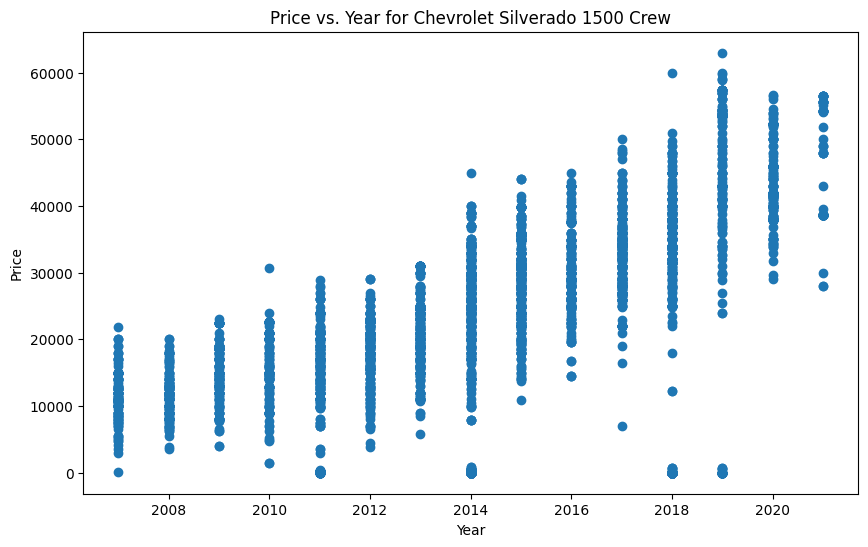

In [2339]:
plt.figure(figsize=(10, 6))
plt.scatter(carmodel_data['year'], carmodel_data['price'])
plt.title('Price vs. Year for Chevrolet Silverado 1500 Crew')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

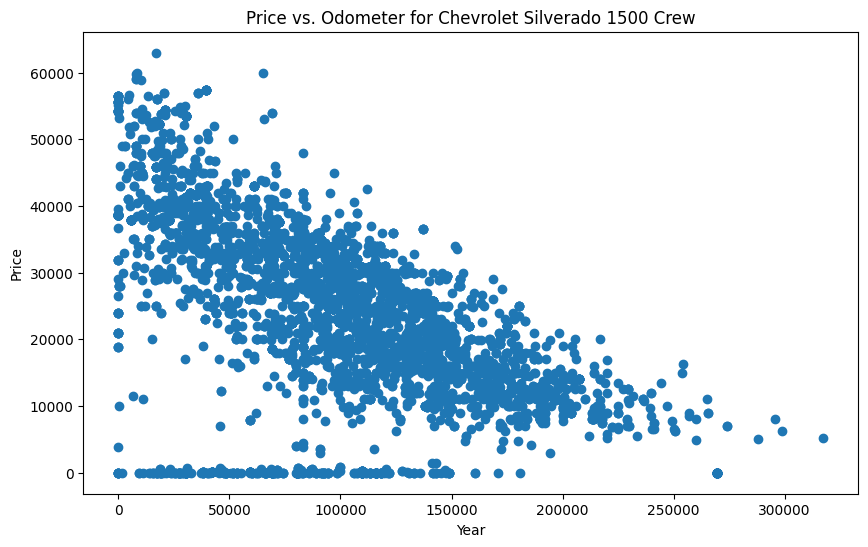

In [2340]:
plt.figure(figsize=(10, 6))
plt.scatter(carmodel_data['odometer'], carmodel_data['price'])
plt.title('Price vs. Odometer for Chevrolet Silverado 1500 Crew')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

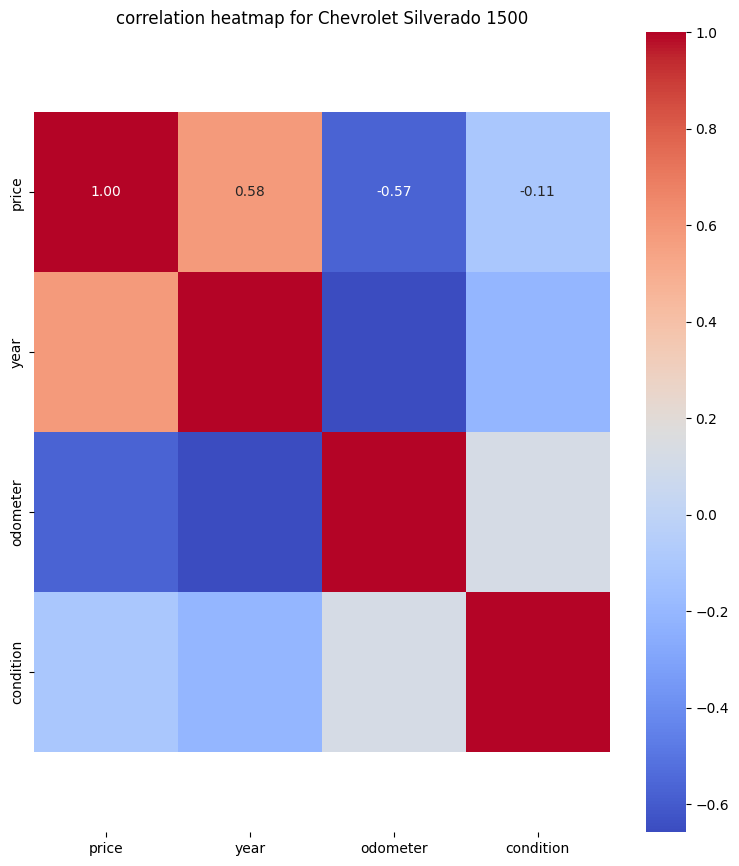

In [2341]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(carmodel_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Adjust layout to make room for the colorbar
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)

# Fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# Show the plot
plt.title(f'correlation heatmap for {modelname}')
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [2342]:
# Initialize all the models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.001)

In [2343]:
#carmodel_data_year = carmodel_data[carmodel_data['year'] == 2020].drop(['year'], axis=1) 

X = carmodel_data[['year', 'condition', 'odometer']] 
y = carmodel_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2344]:
carmodel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4137 entries, 28 to 426419
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      4137 non-null   int64  
 1   year       4137 non-null   float64
 2   odometer   4137 non-null   float64
 3   condition  4137 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 161.6 KB


In [2345]:
linear_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.001)

In [2346]:
# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

In [2347]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

mseridge = mean_squared_error(y_test, y_pred_ridge)
r2ridge = r2_score(y_test, y_pred_ridge)

print(f"Mean Squared Error Ridge: {mseridge}")
print(f"R^2 Score Ridge: {r2ridge}")

mselasso = mean_squared_error(y_test, y_pred_lasso)
r2lasso = r2_score(y_test, y_pred_lasso)

print(f"Mean Squared Error Lasso: {mselasso}")
print(f"R^2 Score Lasso: {r2lasso}")

mserf = mean_squared_error(y_test, y_pred_rf)
r2rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error Random Forest: {mserf}")
print(f"R^2 Score Random Forest: {r2rf}")

msegb = mean_squared_error(y_test, y_pred_gb)
r2gb = r2_score(y_test, y_pred_gb)

print(f"Mean Squared Error Random Forest: {msegb}")
print(f"R^2 Score Random Forest: {r2gb}")


Mean Squared Error: 107164115.8049068
R^2 Score: 0.40542417108362294
Mean Squared Error Ridge: 107164054.18755631
R^2 Score Ridge: 0.40542451295353865
Mean Squared Error Lasso: 107164115.92674735
R^2 Score Lasso: 0.40542417040761825
Mean Squared Error Random Forest: 41531163.23004948
R^2 Score Random Forest: 0.7695737456713343
Mean Squared Error Random Forest: 66586923.98667346
R^2 Score Random Forest: 0.6305575310634404


In [2348]:

# Define a range of alpha values
alpha_values = [0.01, 0.1, 1, 10, 100]

# RidgeCV automatically performs Leave-One-Out Cross-Validation if the dataset is small, or K-Fold CV otherwise
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)

# Fit model
ridge_cv.fit(X_train, y_train)

# Optimal alpha value
print("Optimal Ridge alpha value:", ridge_cv.alpha_)

Optimal Ridge alpha value: 100.0


In [2349]:
# Define a range of alpha values
alpha_values = [0.001, 0.01, 0.1, 1, 10]

# LassoCV for automatic alpha selection via cross-validation
lasso_cv = LassoCV(alphas=alpha_values, max_iter=10000, cv=5)

# Fit model
lasso_cv.fit(X_train, y_train)

# Optimal alpha value
print("Optimal Lassoalpha value:", lasso_cv.alpha_)

Optimal Lassoalpha value: 10.0


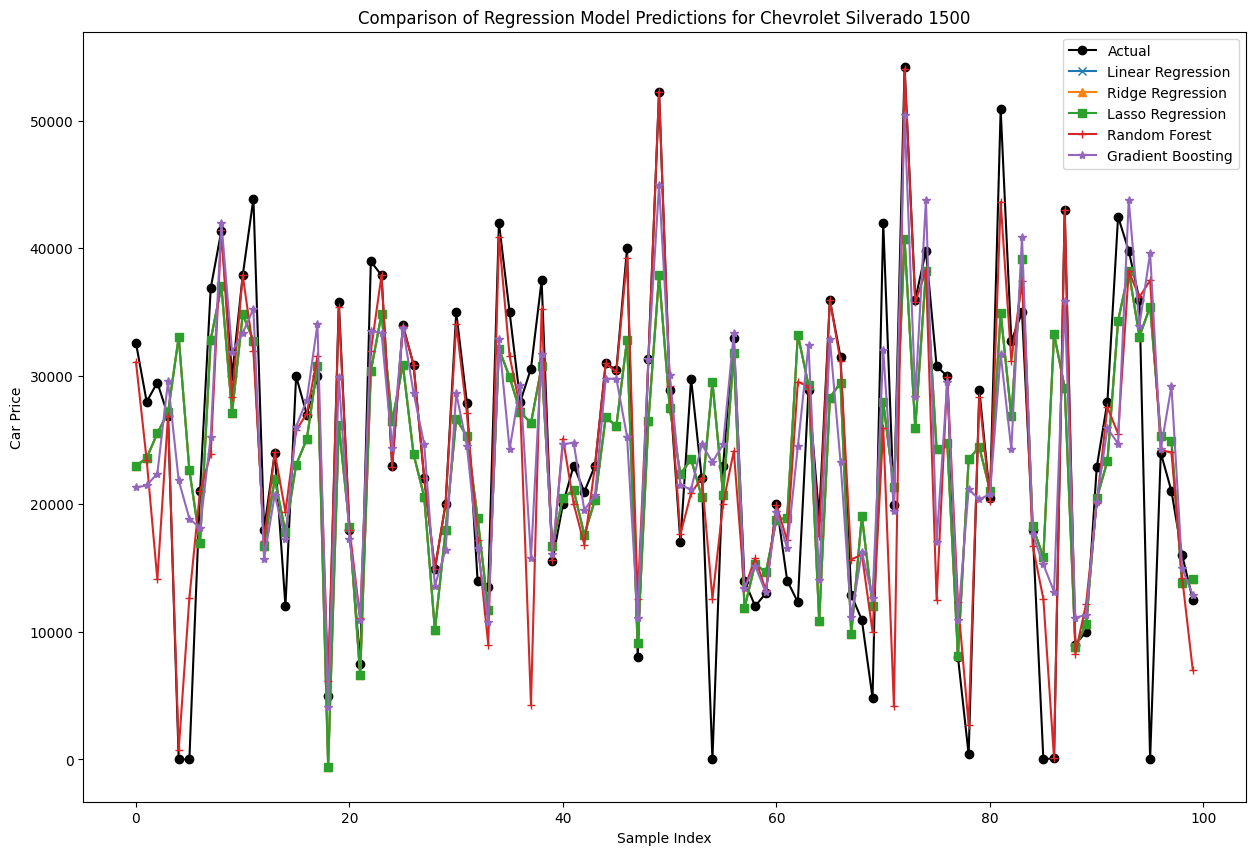

In [2350]:
sample_size = 100
indices = range(sample_size)

# Actual data
y_test_sample = y_test[:sample_size]

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(indices, y_test_sample, label='Actual', color='black', marker='o')

# Add each model's predictions
plt.plot(indices, y_pred_linear[:sample_size], label='Linear Regression', marker='x')
plt.plot(indices, y_pred_ridge[:sample_size], label='Ridge Regression', marker='^')
plt.plot(indices, y_pred_lasso[:sample_size], label='Lasso Regression', marker='s')
plt.plot(indices, y_pred_rf[:sample_size], label='Random Forest', marker='+')
plt.plot(indices, y_pred_gb[:sample_size], label='Gradient Boosting', marker='*')

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('Car Price')
plt.title(f'Comparison of Regression Model Predictions for {modelname}')
plt.legend()

# Show plot
plt.show()

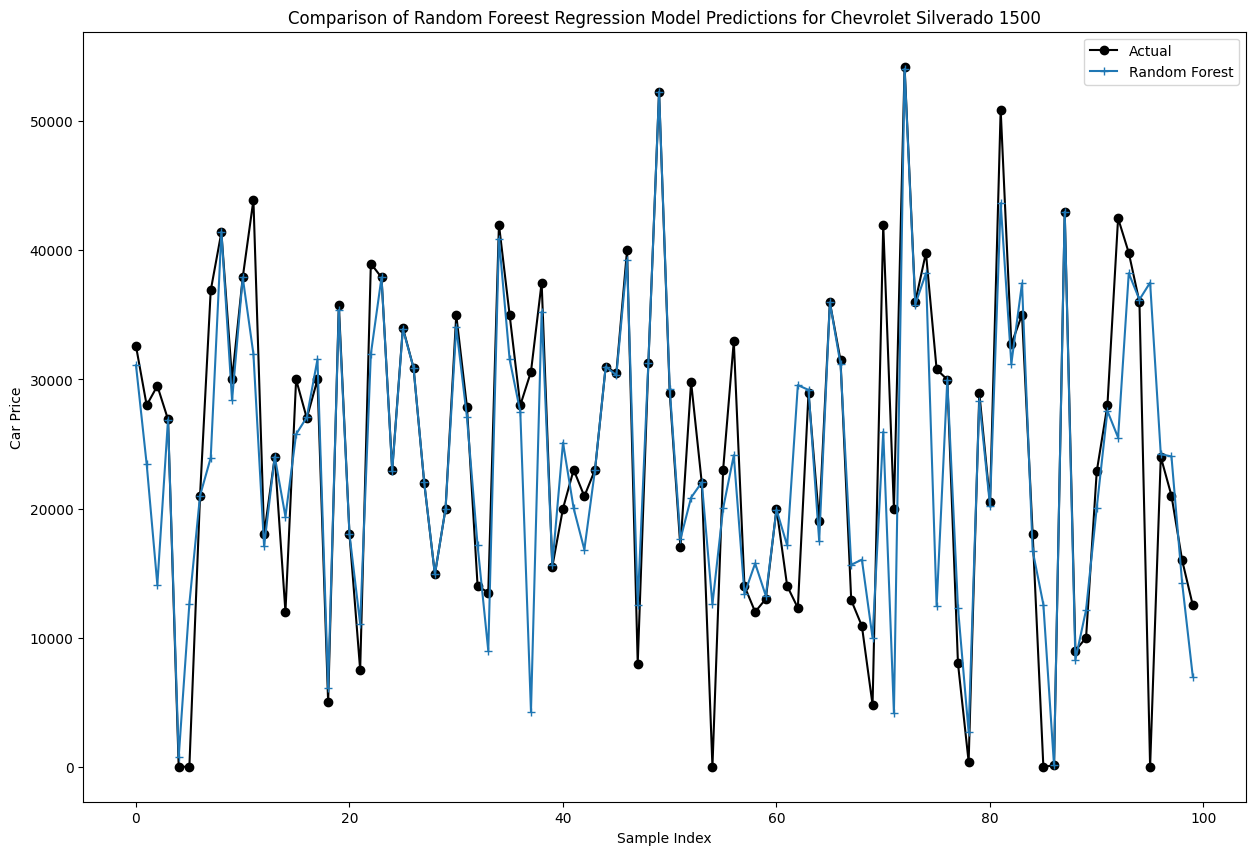

In [2351]:
sample_size = 100
indices = range(sample_size)

# Actual data
y_test_sample = y_test[:sample_size]

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(indices, y_test_sample, label='Actual', color='black', marker='o')

# Let's look the best model
plt.plot(indices, y_pred_rf[:sample_size], label='Random Forest', marker='+')

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('Car Price')
plt.title('Comparison of Random Foreest Regression Model Predictions')
plt.title(f'Comparison of Random Foreest Regression Model Predictions for {modelname}')
plt.legend()
plt.savefig('images/prediction')

# Show plot
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [2352]:
def model_count(df, manufacturer, model,):
    return ((df['manufacturer'] == manufacturer) & (df['model'] == model)).sum()

In [2353]:
def init_model_data(manufacturer, model):
    manufacturer_lc = manufacturer.lower()
    model_lc = model.lower()
    
    df = load_data()
    df = scope_data(df, manufacturer_lc)
    
    mc = model_count(df, manufacturer_lc, model_lc)
    
    if mc == 0:
        raise ValueError(f"cannot find {manufacturer} {model}")
    
    outliers_dict = detect_outliers_by_model_and_year(df, 'price')
    df = clean_outliers(df, outliers_dict)
        
    model_data = model_data = df[(df['manufacturer'] == manufacturer.lower()) & (df['model'] == model.lower())]
    model_data = model_data[['price', 'year', 'odometer', 'condition']]
    
    model_data = encode_data(model_data)
    
    return model_data.copy()

In [2354]:
def test_set_evaluation(manufacturer, model, year):
    
    model_data = init_model_data(manufacturer, model)
    
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    X = model_data[['year', 'condition', 'odometer']] 
    y = model_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    random_forest_model.fit(X_train, y_train)
    y_pred = random_forest_model.predict(X_test)
    errors = abs(y_pred - y_test)

    # Comparing Predicted Values with Actual Values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line for reference
    plt.title('Predicted vs. Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.savefig('images/pred_vs_actual.png')
    plt.show()


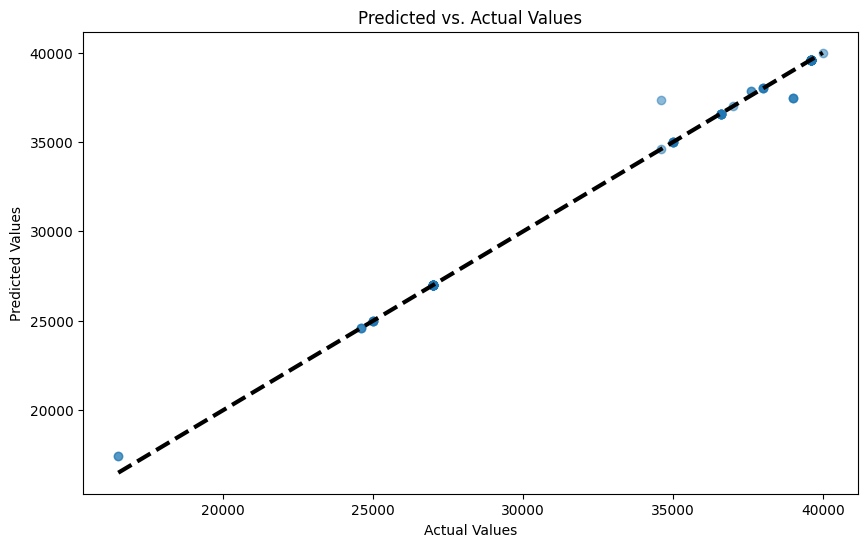

In [2355]:
test_set_evaluation('Chevrolet', 'Silverado 1500 Crew', 2020)

In [2356]:
# finally we write function to provide predicted price using learning from all above

def predict_price(manufacturer, model, year, condition, odometer):
    
    model_data = init_model_data(manufacturer, model)

    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    X = model_data[['year', 'condition', 'odometer']] 
    y = model_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    random_forest_model.fit(X_train, y_train)
        
    # Create the input array
    #print(label_encoder.classes_)
    try:
        condition_encoded = label_encoder.transform([condition])[0]
    except ValueError:
        print(f"Value '{condition}' was not seen during the fitting process.")

    input_df = pd.DataFrame([[year, condition_encoded, odometer]], columns=X_train.columns)

    # Predict the price
    predicted_price = random_forest_model.predict(input_df)

    return predicted_price[0]

In [2357]:
car_details = {
    'manufacturer': 'Chevrolet',
    'model': 'Silverado 1500 Crew',
    'year': 1990,
    'condition': 'good',
    'odometer': 10000
}

pred_price = predict_price(**car_details)
for key, value in car_details.items():
    print(f"{key}: {value}")
print(f"predicted price: ${pred_price}")

manufacturer: Chevrolet
model: Silverado 1500 Crew
year: 1990
condition: good
odometer: 10000
predicted price: $24221.3


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.